# Understanding Underfunded Pension Liabilities and Pension Spiking

Public pension funds in CA have large unfunded liabilities, i.e., the promises made to current and future retirees greatly exceed the ability of the pension funds to pay. 

This project analyzes the funding shortfall by using open data sets of salary and pension payments for employees and retirees at the City of San Jose. In addition, a model using linear regression is used to help identify end of year salary manipulation that indicates "pension spiking".

# Contents
- [Data Cleaning and EDA](#data-cleaning)
    - [Pension Data](#pension-data)
    - [Pre-retirement Salary Data](#retirement-data)
- [Joining Tables](#joining-tables)
- [Salary and Pension Data for Analysis](#salary-4-analysis)

<div id='data-cleaning'/>
# Data Cleaning and EDA

Import the required libraries:

In [13]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<div id='pension-data'/>
## Pension Data

Employees at the City of San Jose are covered by two pension funds:

- The Police and Fire Retirment Plan
- The Federated City Employees Retirement System (for employees other than Police and Fire)

After importing the data, empty rows are deleted.

In [14]:
# Read pension data from SJ Fed City Employees Retirement System, drop the empty columns, and filter by employees
# who retired in 2015

df_1 = pd.read_csv('san-jose-federated-city-employees-retirement-syste-2015.csv')
df_1 = df_1.drop(["job_title","employer","benefits_amount","notes"], axis=1)
ret_1 = df_1[df_1["year_of_retirement"]==2015]

df_2 = pd.read_csv('san-jose-police-and-fire-retirement-plan-2015.csv')
df_2 = df_2.drop(["job_title","employer","benefits_amount","notes"], axis=1)
ret_2 = df_2[df_2["year_of_retirement"]==2015]
df = pd.concat([df_1,df_2])
df.shape

(6077, 8)

### Federated Pension Plan

The pension funds pay out two types of pensions - retirement pensions and disability pensions. Lets do some basic calculations to understand how much is paid out, by the year when the employee started receiving a pension.


- Police and Fire Plan pays out slightly more than Federated Plan
- But Federated Plan covers more than twice as many retirees
- Police and Fire Plan pays significantly more disability pensions than the Federated Plan

In [16]:
#df_1 has 3979 rows
#3768 getting retirement pension
# 211 getting disability pension

dis_count = len(df_1[df_1["disability_amount"] != 0].index)
ret_count = len(df_1[df_1["pension_amount"] != 0].index)
tot_count = dis_count + ret_count

ret_count

print "The Federated Pension Fund is paying out ", len(df_1.index)," pensions:"
print "* ", len(df_1[df_1["disability_amount"] != 0].index)-1 ," disability pensions", "(",'{:.1%}'.format(float(dis_count)/tot_count),")"
print "* ", len(df_1[df_1["disability_amount"] == 0].index)-1 ," retirement pensions", "(",'{:.1%}'.format(float(ret_count)/tot_count),")"

tot_dis_pay = df_1["disability_amount"].sum()
tot_ret_pay = df_1["pension_amount"].sum()
tot_pay = tot_dis_pay + tot_ret_pay

print
print "Total disability payouts: ",'${:,.2f}'.format(tot_dis_pay), "(",'{:.1%}'.format(tot_dis_pay/tot_pay),")"
print "Total retirement payouts: ",'${:,.2f}'.format(tot_ret_pay), "(",'{:.1%}'.format(tot_ret_pay/tot_pay),")"

The Federated Pension Fund is paying out  3979  pensions:
*  210  disability pensions ( 5.3% )
*  3767  retirement pensions ( 94.7% )

Total disability payouts:  $6,476,330.04 ( 3.8% )
Total retirement payouts:  $164,997,100.20 ( 96.2% )


In [17]:
dis_count = len(df_2[df_2["disability_amount"] != 0].index)
ret_count = len(df_2[df_2["pension_amount"] != 0].index)
tot_count = dis_count + ret_count

ret_count

print "The Police and Fire Pension Fund is paying out ", len(df_2.index)," pensions:"
print "* ", len(df_2[df_2["disability_amount"] != 0].index)-1 ," disability pensions", "(",'{:.1%}'.format(float(dis_count)/tot_count),")"
print "* ", len(df_2[df_2["disability_amount"] == 0].index)-1 ," retirement pensions", "(",'{:.1%}'.format(float(ret_count)/tot_count),")"

tot_dis_pay = df_2["disability_amount"].sum()
tot_ret_pay = df_2["pension_amount"].sum()
tot_pay = tot_dis_pay + tot_ret_pay

print
print "Total disability payouts: ",'${:,.2f}'.format(tot_dis_pay), "(",'{:.1%}'.format(tot_dis_pay/tot_pay),")"
print "Total retirement payouts: ",'${:,.2f}'.format(tot_ret_pay), "(",'{:.1%}'.format(tot_ret_pay/tot_pay),")"

The Police and Fire Pension Fund is paying out  2098  pensions:
*  925  disability pensions ( 44.1% )
*  1171  retirement pensions ( 55.9% )

Total disability payouts:  $77,789,048.40 ( 42.6% )
Total retirement payouts:  $104,677,275.72 ( 57.4% )


Bar charts provide more detail about how pension payments break down by retirement year.  Notice the large spikes in retirees around 2010 and 1992, when the City cut head count through inducements to retire. 

Also, notice the larger proportion of disability pensions in the Police and Fire Pension Fund. 

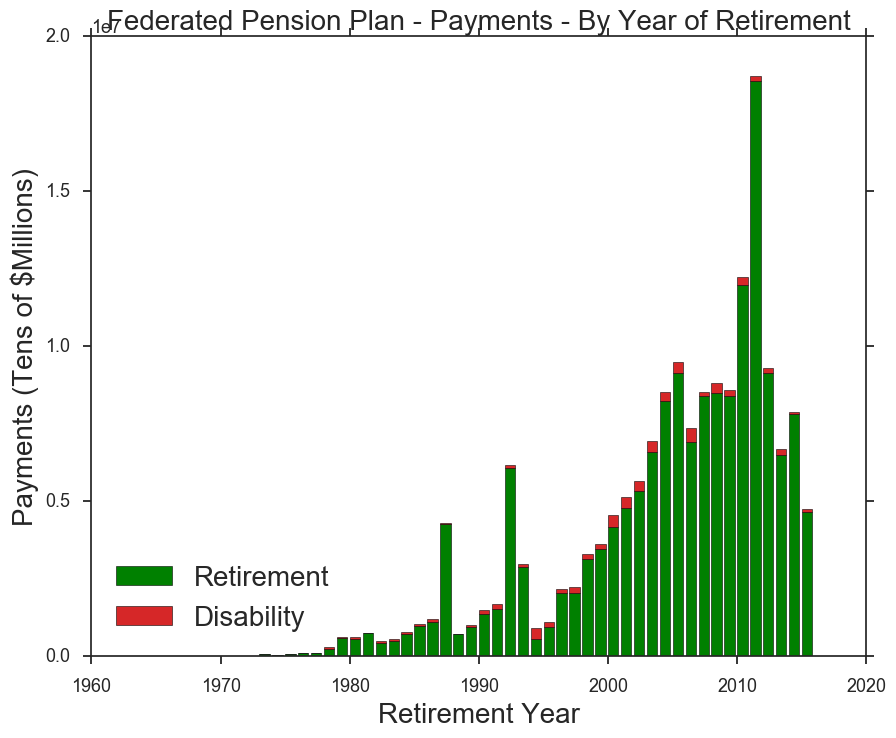

In [18]:
a = df_1.groupby("year_of_retirement")[["pension_amount", "disability_amount"]].sum()
a["year"] = a.index

pension_pay = a["pension_amount"]
disability_pay = a["disability_amount"]
x = a["year"]

plt.figure(figsize=(10,8))
p1 = plt.bar(x, pension_pay, color='g')
p2 = plt.bar(x, disability_pay, bottom=pension_pay,color='#d62728')

 
plt.ylabel('Payments (Tens of $Millions)',fontsize=20)
plt.xlabel('Retirement Year',fontsize=20)
plt.title("Federated Pension Plan - Payments - By Year of Retirement",fontsize=20)
plt.legend(['Retirement', 'Disability'], loc='lower left',fontsize=20)


#plt.show()
plt.savefig('/Users/andrewgstark/Desktop/DSI-SF-4-andrewgstark/gitpages/andrewgstark.github.io/JEKYLL-SITE-REPOSITORY-NAME/myblog/assets/pensionpayments_federated.png',transparent=True)

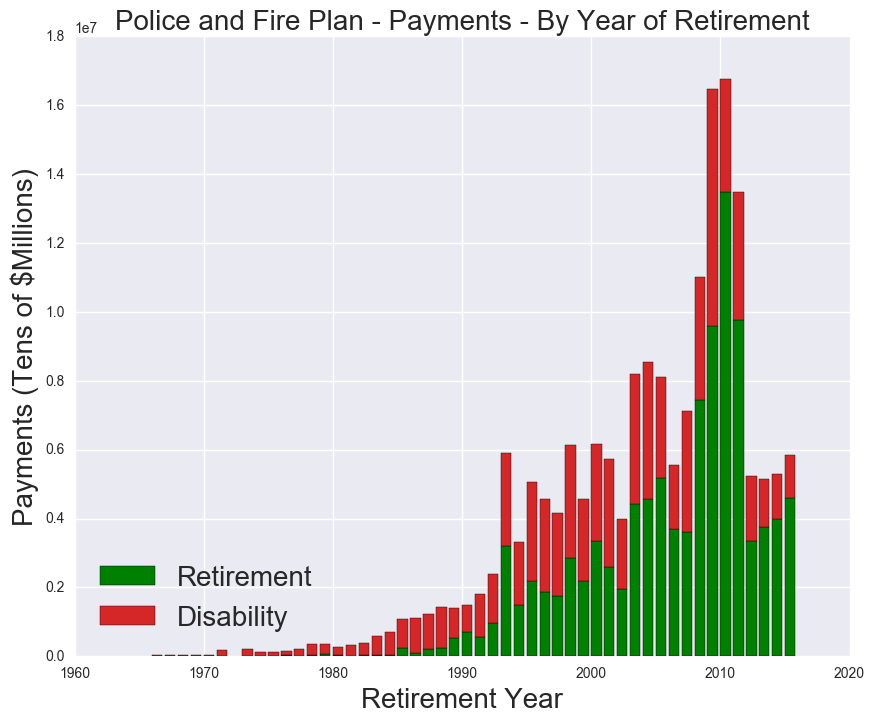

In [9]:
a = df_2.groupby("year_of_retirement")[["pension_amount", "disability_amount"]].sum()
a["year"] = a.index

pension_pay = a["pension_amount"]
disability_pay = a["disability_amount"]
x = a["year"]

plt.figure(figsize=(10,8))
p1 = plt.bar(x, pension_pay, color='g')
p2 = plt.bar(x, disability_pay, bottom=pension_pay,color='#d62728')

plt.ylabel('Payments (Tens of $Millions)',fontsize=20)
plt.xlabel('Retirement Year',fontsize=20)

plt.title("Police and Fire Plan - Payments - By Year of Retirement",fontsize=20)

plt.legend(['Retirement', 'Disability'], loc='lower left',fontsize=20)


#plt.show()
plt.savefig('/Users/andrewgstark/Desktop/DSI-SF-4-andrewgstark/gitpages/andrewgstark.github.io/JEKYLL-SITE-REPOSITORY-NAME/myblog/assets/pensionpayments_police_and_fire.png',transparent=True)

For our analysis of how pensions are determined by final income, we need data about retirement pensions and the retiree's years of service. Retirement pensions and pensions paid to beneficiaries are filtered out.

Also, years_of_service is cast as a float to permit calculations.

In [19]:
df_1 = df_1[df_1["disability_amount"] !=0]
df_1 = df_1[df_1["years_of_service"] !="Beneficiary"]

service_years = []
for item in df_1["years_of_service"]:
    service_years.append(float(item))
df_1["years_of_service"] = service_years

a = df_1.groupby("year_of_retirement")[["years_of_service"]].mean()
a["year"] = a.index

# 

df_2 = df_2[df_2["disability_amount"] !=0]
df_2 = df_2[df_2["years_of_service"] !="Beneficiary"]

service_years = []
for item in df_2["years_of_service"]:
    service_years.append(float(item))
df_2["years_of_service"] = service_years

b = df_2.groupby("year_of_retirement")[["years_of_service"]].mean()
b["year"] = b.index

In [20]:
c = pd.concat([df_1,df_2])

To see the average years of service at retirement, the pension data is grouped by retirement year and plotted. 

Notice the large number of disability retirements among Police and Fire personnel, at late stages in their carreer. The Federated Plan had far fewer disability retirements, and they seem to be more evenly dispersed in the range of years of service.

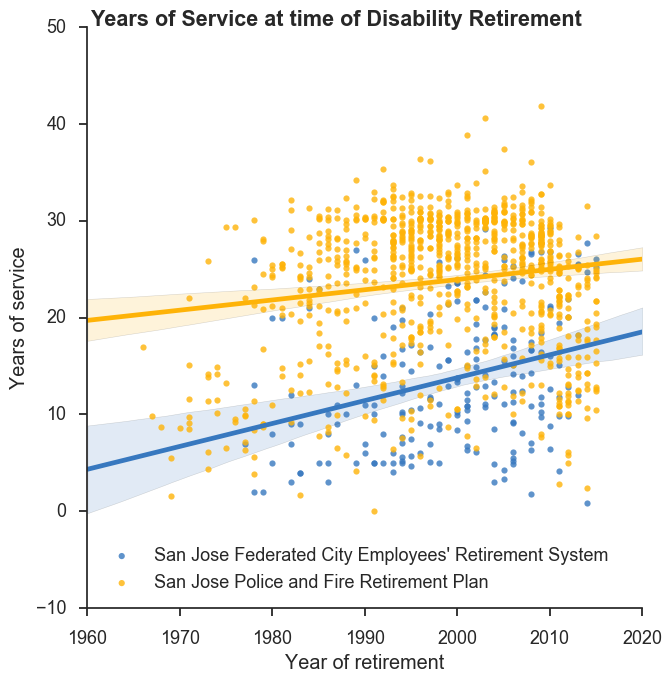

In [21]:
sns.set(style="ticks", context="talk")

# Make a custom sequential palette using the cubehelix system
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
pal = sns.xkcd_palette(colors)
plt.figure(figsize=(10,8))

# Plot tip as a function of toal bill across days
g = sns.lmplot(x="year_of_retirement", y="years_of_service", hue = "pension_system", data=c,
               palette=pal, size=7,legend=False)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Year of retirement", "Years of service")
g.fig.suptitle('Years of Service at time of Disability Retirement',fontweight="bold")
plt.legend(loc='lower left')

plt.savefig('/Users/andrewgstark/Desktop/DSI-SF-4-andrewgstark/gitpages/andrewgstark.github.io/JEKYLL-SITE-REPOSITORY-NAME/myblog/assets/service_at_disretire.png',transparent=True)

Remove the disability pensions, and cast years_of_service as a float.

In [22]:
# Only run this cell once
# Remove the disability pensions, plus pensions going to beneficiaries

df = df[df["pension_amount"] !=0]
df = df[df["years_of_service"] !="Beneficiary"]

service_years = []
for item in df["years_of_service"]:
    service_years.append(float(item))
df["years_of_service"] = service_years

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4201 entries, 0 to 2096
Data columns (total 8 columns):
employee_name         4201 non-null object
pension_amount        4201 non-null float64
disability_amount     4201 non-null float64
total_amount          4201 non-null float64
years_of_service      4201 non-null float64
year_of_retirement    4201 non-null int64
year                  4201 non-null int64
pension_system        4201 non-null object
dtypes: float64(4), int64(2), object(2)
memory usage: 295.4+ KB


We group retirement pensions by the year_of_retirement and plot them against the service years of each retiree. Notice how the years of service for the Police and Fire Pension Fund is steadily decreasing. I attribute this to the "3% at 50" retirement formula arising from SB 400 passed in 1999. 

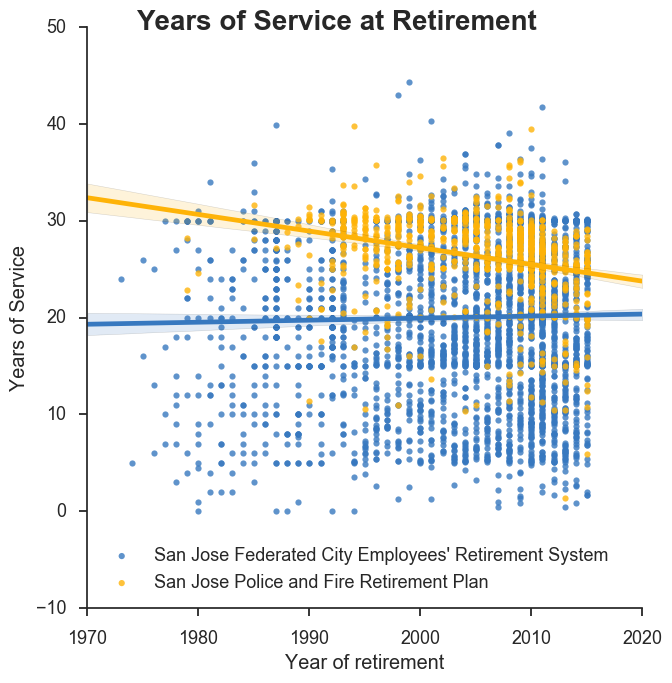

In [23]:
sns.set(style="ticks", context="talk")

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
pal = sns.xkcd_palette(colors)
plt.figure(figsize=(10,8))

g = sns.lmplot(x="year_of_retirement", y="years_of_service", hue = "pension_system", data=df,
               palette=pal, size=7,legend=False)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Year of retirement", "Years of Service")
g.fig.suptitle('Years of Service at Retirement',fontweight="bold",fontsize=20)
plt.legend(loc='lower left')

plt.savefig('/Users/andrewgstark/Desktop/DSI-SF-4-andrewgstark/gitpages/andrewgstark.github.io/JEKYLL-SITE-REPOSITORY-NAME/myblog/assets/service_vs_yearofretire.png',transparent=True)

To get a better understanding of the pensions paid by the two fund, we use describe() to generate some summary statistics.

In [24]:
df[df["pension_system"] == "San Jose Federated City Employees' Retirement System"].describe()

,pension_amount,disability_amount,total_amount,years_of_service,year_of_retirement,year
count,3276.000000,3276.0,3276.000000,3276.000000,3276.000000,3276.0
mean,46875.434432,0.0,46875.434432,20.033294,2003.971001,2015.0
std,26822.587379,0.0,26822.587379,8.117080,8.749303,0.0
min,238.440000,0.0,238.440000,0.000000,1973.000000,2015.0
25%,26800.050000,0.0,26800.050000,15.000000,1999.750000,2015.0
50%,44156.340000,0.0,44156.340000,20.445000,2006.000000,2015.0
75%,62886.960000,0.0,62886.960000,27.142500,2011.000000,2015.0
max,194250.120000,0.0,194250.120000,44.300000,2015.000000,2015.0


In [25]:
df[df["pension_system"] == "San Jose Police and Fire Retirement Plan"].describe()

,pension_amount,disability_amount,total_amount,years_of_service,year_of_retirement,year
count,925.000000,925.0,925.000000,925.000000,925.000000,925.0
mean,102388.986422,0.0,102388.986422,26.305946,2005.295135,2015.0
std,34886.875844,0.0,34886.875844,4.343327,7.047491,0.0
min,4059.720000,0.0,4059.720000,1.340000,1979.000000,2015.0
25%,81937.440000,0.0,81937.440000,25.040000,2000.000000,2015.0
50%,100862.280000,0.0,100862.280000,27.130000,2008.000000,2015.0
75%,122042.640000,0.0,122042.640000,29.120000,2011.000000,2015.0
max,249286.560000,0.0,249286.560000,39.850000,2015.000000,2015.0


Rename the columns names, to make them more meaningful.

In [26]:
#combine the 2 dataframes from the 2 retirement systems and rename the columns

frames = [ret_1,ret_2]
retirees = pd.concat(frames)
retirees.columns = ["retiree_name","pension_15","disability_15","total_pension_15","years_of_service","year_of_retirement","year","pension_system"]

Remove the pensions paid to beneficiaries, and the disability pensions. These pensions are not going to be used in our analysis. 

In [29]:
# filter out pension beneficiaries and those receive disability pensions

retirees = retirees[retirees["years_of_service"]!="Beneficiary"]

retirees = retirees[retirees["disability_15"] == 0.]

To be able to make calculations using years_of_service, convert that field to a float.

In [30]:
# change years of service from object to float

years_of_service = retirees["years_of_service"]
yos_float= []
for duration in years_of_service:
    duration = float(duration)
    yos_float.append(duration)
retirees["years_of_service"] = yos_float

There were three retiree names in the pension information file that were duplicated for unknown reasons. I removed the duplicate name's row which had the higher pension amount.

In [35]:
# Find duplicate names among those who retired in 2015 - there are three
#retirees["retiree_name"].value_counts()

retiree_dups = ["Gilbert Hernandez","David Arroyo", "Ann Danforth"]
retirees.loc[retirees['retiree_name'].isin(retiree_dups)]

,retiree_name,pension_15,disability_15,total_pension_15,years_of_service,year_of_retirement,year,pension_system
622,David Arroyo,69688.92,0.0,69688.92,30.06,2015,2015,San Jose Federated City Employees' Retirement ...
992,Gilbert Hernandez,58568.40,0.0,58568.40,29.01,2015,2015,San Jose Federated City Employees' Retirement ...
3816,Ann Danforth,7610.04,0.0,7610.04,1.63,2015,2015,San Jose Federated City Employees' Retirement ...


In [34]:
# It's not clear why these retirees have duplicate records. Will retain the record with the higher pension payment,
# and delete the other one. 
retirees.drop([796,1074,3817], inplace=True)

<div id='retirement-data'/>
## Pre-Retirement Salary Data

There are three files for the City of San Jose's salary data, one for each year. 

Since duplicate names will cause issues when joining the tables, keep track of the duplicate names.

In [37]:
# Read the salary files and find the duplicate names in the payroll files

def find_double_names(df, name_field):
    employee_name_counts = df[name_field].value_counts()
    double_names = []
    for name in employee_name_counts.index:
        if employee_name_counts.loc[name] > 1:
            double_names.append(name)
    return double_names

df_13 = pd.read_csv('City Comp 2013.csv')
df_14 = pd.read_csv('City Comp 2014.csv')
df_15 = pd.read_csv('City Comp 2015.csv')

To understand how salary spending varies by department, we group 2015 salary data by department. 

Salary expenses for Police and Fire dwarf the other departments. Also notice the use of overtime by these departments. 

In statements with the media, Police cite understaffing as the reason for the use of overtime. 

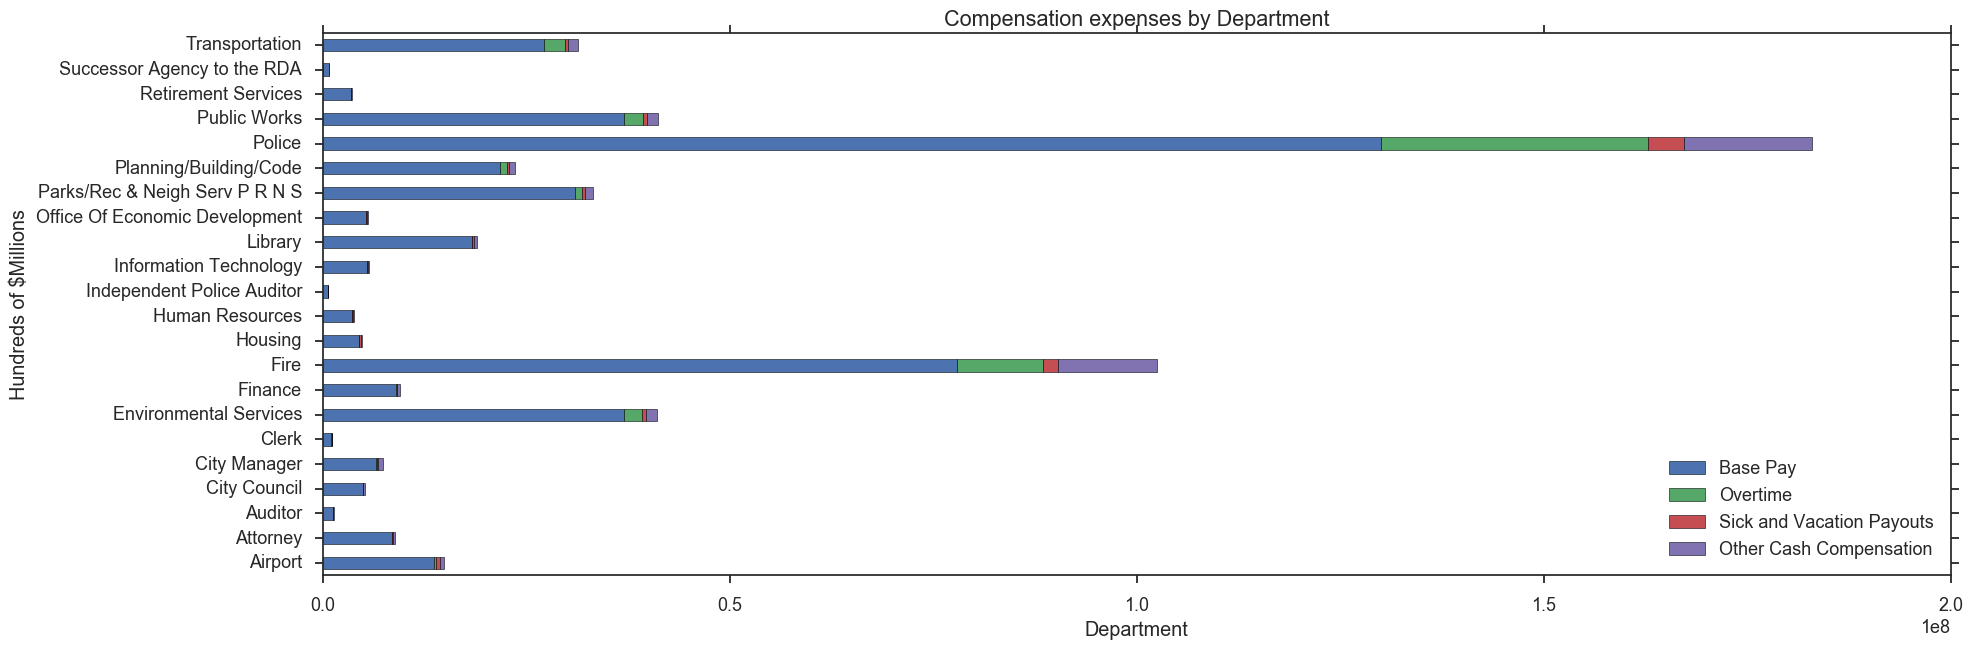

In [42]:
a = df_15.groupby("Department")["Total Cash Compensation",'Base Pay','Overtime','Sick and Vacation Payouts','Other Cash Compensation','Retirement Contributions - City Paid*'].sum()
a["Department"] = a.index
a.fillna(value=0,inplace=True)
a.columns
b = a[['Base Pay', 'Overtime','Sick and Vacation Payouts', 'Other Cash Compensation']]

my_plot = b.plot(kind='barh',stacked=True,title="Compensation expenses by Department",figsize=(21, 7))
my_plot.set_xlabel("Department")
my_plot.set_ylabel("Hundreds of $Millions")

plt.savefig('/Users/andrewgstark/Desktop/DSI-SF-4-andrewgstark/gitpages/andrewgstark.github.io/JEKYLL-SITE-REPOSITORY-NAME/myblog/assets/compensation_by_department.png',transparent=True)


Append the year to the column names, in preparation for joining the tables.

In [43]:
# append the year to the column names, so we know the year the data came from 

def change_col_names(df,year):
    new_cols = []
    for col in df.columns:
        new_cols.append(col+year)
    df.columns = new_cols
    return None
    
change_col_names(df_15, "-2015")
change_col_names(df_14, "-2014")
change_col_names(df_13, "-2013")

In [44]:
# Rename the employee's name column, which is the field to join the 3 tables

df_15.rename(columns={'Name-2015':'Name'}, inplace=True)
df_14.rename(columns={'Name-2014':'Name'}, inplace=True)
df_13.rename(columns={'NAME-2013':'NAME'}, inplace=True)


To better undestand how much the City spends on retirement costs, we caculate retirement costs as a percent of total salary expenses. Retirement expensens represent more then half of salary spending!

In [45]:
a = df_15.groupby(["Department-2015"])["Total Cash Compensation-2015", "Retirement Contributions - City Paid*-2015", 'Long Term Disability, Life, Medicare-2015','Misc Employment Related Costs-2015'].sum()
a["City Paid Retirement Cost as Percent of Total Cash Pay"] = a["Retirement Contributions - City Paid*-2015"]/a["Total Cash Compensation-2015"]
a["LTD, Life, Medicare as Percent of Total Cash Pay"] = a["Long Term Disability, Life, Medicare-2015"]/a["Total Cash Compensation-2015"]
a["Misc Employer Costs as Percent of Total Cash Pay"] = a["Misc Employment Related Costs-2015"]/a["Total Cash Compensation-2015"]
a.sort_values("Total Cash Compensation-2015",inplace=True,ascending=False)
a[["Total Cash Compensation-2015","Retirement Contributions - City Paid*-2015","City Paid Retirement Cost as Percent of Total Cash Pay"]].head()

,Total Cash Compensation-2015,Retirement Contributions - City Paid*-2015,City Paid Retirement Cost as Percent of Total Cash Pay
Department-2015,,,
Police,1.831891e+08,1.011666e+08,0.552252
Fire,1.024767e+08,7.008535e+07,0.683915
Public Works,4.122518e+07,2.074121e+07,0.503120
Environmental Services,4.104540e+07,2.078987e+07,0.506509
Parks/Rec & Neigh Serv P R N S,3.366161e+07,1.137902e+07,0.338041


Find the double names in all of the salary files (2013 through 2015).

In [46]:
double_name_list = list(set(find_double_names(df_13, "NAME") + find_double_names(df_14, "Name") + find_double_names(df_15, "Name")))
double_name_list.sort()

In [47]:
double_name_list

['Brugge,Thomas',
 'Garcia,Michael',
 'Guerrero,Joseph',
 'Ibanez,Jorge J',
 'Jones,Michael A',
 'Lopez,Sandra',
 'Martin,Christopher',
 'Martinez,Benjamin',
 'Navarro,Daniel',
 'Ngo,Tam',
 'Nguyen,Anh',
 'Nguyen,Cindy',
 'Nguyen,Hieu',
 'Nguyen,My',
 'Nguyen,Peter',
 'Nguyen,Viet',
 'Ortiz,Yolanda',
 'Perez,Martin',
 'Romero,David A',
 'Tran,Thanh',
 'Vazquez,Jose',
 'Webb,Christopher',
 'Wilson,James A',
 'Wong,Eric']

Names in the salary files are in the format <last> <prefix>, <first> <MI>, while in the pension file names use <first> <last>. To prepare a new name field to join the tables, we remove commas and split the different words in the name.

In [48]:
def find_name_parts(df, name_field):
    df["name_parts"] = df[name_field].map(lambda x: x.replace(",", " "))
    df["name_parts"] = df["name_parts"].map(lambda x: x.split())
    df["name_parts"].astype(str)
    return None

find_name_parts(df_15, "Name")
find_name_parts(df_14, "Name")
find_name_parts(df_13, "NAME")

Name suffixes like "Jr" or "III" appear in the salary files, but they are not used in the pension file, so we remove them in the field used for name parts.

In [49]:
def remove_name_suffixes(df):
    i = ["Jr", "II", "III", "Sr", "Jr."]
    name_parts_cleaned = []
    for l in df["name_parts"]:
        for w in l:
            if w in i:
                l.remove(w)
        name_parts_cleaned.append(l)
    df["name_parts"] = name_parts_cleaned
    return None

remove_name_suffixes(df_15)
remove_name_suffixes(df_14)
remove_name_suffixes(df_13)

From the name parts, we create a new field to creat a name in the <first> <last> format. The rules are a little arbitrary (first and middle names can have more than one word) but I'm confident the following creates a valid name most of the time.

I'm planning to revisit this code in the future, with the goal of matching more names.

In [50]:
def make_firstlast_name(df, name_parts_field):
    first_last = []
    for item in df[name_parts_field]:
        if len(item) == 2:
            first_last.append(item[1]+' '+item[0])
        if len(item) == 3:
            first_last.append(item[1]+' '+item[0])
        if len(item) == 4:
            first_last.append(item[2]+' '+item[0]+' '+item[1])
        if len(item) == 5:
            first_last.append(item[3]+' '+item[0]+' '+item[1]+' '+item[2])
        if len(item) == 6:
            first_last.append(item[3]+' '+item[0]+' '+item[1]+' '+item[2])
    df["retiree_name"] = first_last
    return None
    
make_firstlast_name(df_13 ,"name_parts")
make_firstlast_name(df_14 ,"name_parts")
make_firstlast_name(df_15 ,"name_parts")


Duplicate employee names will cause issues when joining the tables. Unless an employee with a duplicate name retires in 2015, it's likely best to delete them. To prepare, we compile a list of all the duplicates. 

In [51]:
# Need to see if any of the duplicate employee names (working from 2013 to 2015) match any 2015 retirees.
# pulll out the names in first last format, and then creat a set to eliminate duplicates

def find_dup_employees_names(df, name_field):
    double_name_fl = []
    for index, row in df.iterrows():
        for name in double_name_list:
            if name == row[name_field]:
                double_name_fl.append(row['retiree_name'])
    return double_name_fl

dup_employee_names = find_dup_employees_names(df_15, "Name") + find_dup_employees_names(df_14, "Name") + find_dup_employees_names(df_13, "NAME")
myset = set(dup_employee_names)

In [52]:
myset

{'Anh Nguyen',
 'Benjamin Martinez',
 'Christopher Martin',
 'Christopher Webb',
 'Cindy Nguyen',
 'Daniel Navarro',
 'David Romero',
 'Eric Wong',
 'Hieu Nguyen',
 'James Wilson',
 'Jorge Ibanez',
 'Jose Vazquez',
 'Joseph Guerrero',
 'Martin Perez',
 'Michael Garcia',
 'Michael Jones',
 'My Nguyen',
 'Peter Nguyen',
 'Sandra Lopez',
 'Tam Ngo',
 'Thanh Tran',
 'Thomas Brugge',
 'Viet Nguyen',
 'Yolanda Ortiz'}

We now compare the list of employee duplicate names with the names of the retirees. There is only one duplicate - James Wilson.

In [53]:
# Need to compare the names in myset with the retiree names in retirees

matches = []
for emp_name in myset:
    for ret_name in retirees['retiree_name']:
        if emp_name == ret_name:
            matches.append(emp_name)
matches

['James Wilson']

In [54]:
retirees[retirees["retiree_name"] == "James Wilson"]

,retiree_name,pension_15,disability_15,total_pension_15,years_of_service,year_of_retirement,year,pension_system
1255,James Wilson,53153.4,0.0,53153.4,30.05,2015,2015,San Jose Federated City Employees' Retirement ...


There were 2 people named "James A Wilson" working in 2015 - an Assoc Engineer and a Mechanic, both from the Public Works departments. I deduced that the Mechanic is the retiree (because payouts in 2015 vastly different 2015 vs 2014 base pay). Delete the unneeded row (the Assoc Engineer) in each of the salary files 2013 through 2015.

In [57]:
df_15.drop([2565], inplace=True)
df_15[df_15["retiree_name"] == "James Wilson"]

,Name,Department-2015,Job Title (as of 12/31/15)-2015,Total Cash Compensation-2015,Base Pay-2015,Overtime-2015,Sick and Vacation Payouts-2015,Other Cash Compensation-2015,Defined Contribution Plan Contributions - City Paid-2015,Medical Dental Vision-2015,Retirement Contributions - City Paid*-2015,"Long Term Disability, Life, Medicare-2015",Misc Employment Related Costs-2015,name_parts,retiree_name
3279,"Wilson,James A",Public Works,Temp Employee Retiree U,77817.78,33991.16,3144.42,40548.0,134.2,NaN,1056.22,3705.68,1130.22,NaN,"[Wilson, James, A]",James Wilson


In [59]:
df_14.drop([2554], inplace=True)
df_14[df_14["retiree_name"] == "James Wilson"]

,Name,Department Name-2014,Job Title (as of 12/31/14)-2014,Total Cash Compensation-2014,Base Pay-2014,Overtime-2014,Sick and Vacation Payouts-2014,Other Cash Compensation-2014,Deferred Comp Paid by Employer-2014,Medical Dental Vision City Paid-2014,Employer's Share Pension Payments-2014,"Long Term Disability, Life, Medicare-2014",Misc Employment Related Costs-2014,name_parts,retiree_name
1935,"Wilson,James A",Public Works,Mechanic,104020.5,69222.4,31185.51,NaN,3612.59,NaN,12998.04,44656.86,1519.09,NaN,"[Wilson, James, A]",James Wilson


In [61]:
df_13.drop([2618], inplace=True)
df_13[df_13["retiree_name"] == "James Wilson"]

,NAME,Department Name-2013,Job Title-2013,Total Cash Compensation-2013,Base Pay-2013,Overtime-2013,Sick and Vacation Payouts-2013,Other Cash Compensation-2013,Deferred Comp Paid by Employer-2013,Medical Dental Vision City Paid-2013,Employer's Share Pension Payments-2013,Retired?-2013,name_parts,retiree_name
2302,"Wilson,James A",General Services,Mechanic,90588.46,67308.8,21339.64,NaN,1940.02,NaN,16139.76,38686.84,No,"[Wilson, James, A]",James Wilson


Now that we have manually deleted the James Wilson row that we don't need, we need to remove James A Wilson from the duplicate names list. So we don't delete the James A Wilson data we do need. Need to research deleting by entry

In [62]:
double_name_list

['Brugge,Thomas',
 'Garcia,Michael',
 'Guerrero,Joseph',
 'Ibanez,Jorge J',
 'Jones,Michael A',
 'Lopez,Sandra',
 'Martin,Christopher',
 'Martinez,Benjamin',
 'Navarro,Daniel',
 'Ngo,Tam',
 'Nguyen,Anh',
 'Nguyen,Cindy',
 'Nguyen,Hieu',
 'Nguyen,My',
 'Nguyen,Peter',
 'Nguyen,Viet',
 'Ortiz,Yolanda',
 'Perez,Martin',
 'Romero,David A',
 'Tran,Thanh',
 'Vazquez,Jose',
 'Webb,Christopher',
 'Wilson,James A',
 'Wong,Eric']

In [63]:
del double_name_list[-2]

It's now safe to remove the duplicate employee names from the salary files. If we don't remove them, there will be many nonsensical matches when joining the tables.

In [64]:
df_13 = df_13[~df_13["NAME"].isin(double_name_list)]
df_14 = df_14[~df_14["Name"].isin(double_name_list)]
df_15 = df_15[~df_15["Name"].isin(double_name_list)]

<div id='joining-tables'/>
## Joining the Tables

Now the data is ready, let's join the salary tables, and the pension file.

In [65]:
u = df_15.merge(df_14, on=['Name'], how='inner')

In [66]:
u.shape

(6513, 29)

In [67]:
df_13.rename(columns={'NAME':'Name'}, inplace=True)
df_13.columns

Index([u'Name', u'Department Name-2013', u'Job Title-2013',
       u'Total Cash Compensation-2013', u'Base Pay-2013', u'Overtime-2013',
       u'Sick and Vacation Payouts-2013', u'Other Cash Compensation-2013',
       u'Deferred Comp Paid by Employer-2013',
       u'Medical Dental Vision City Paid-2013',
       u'Employer's Share Pension Payments-2013', u'Retired?-2013',
       u'name_parts', u'retiree_name'],
      dtype='object')

In [68]:
v = u.merge(df_13, on=['Name'], how='inner')

In [69]:
v.shape

(5672, 42)

In [70]:
v.rename(columns={'retiree_name-2015':'retiree_name'}, inplace=True)

In [71]:
data = v.merge(retirees, on=['retiree_name'], how='inner')

After joining the tables, we found some duplicate names. This is because the <first> <last> name format in the pension file matches other employees with similar names. I carefully looked at the names, and decided which records to delete by looking at department, salary level, payouts, etc.

In [72]:
data["retiree_name"].value_counts()

Ruben Torres             3
Kenneth Johnson          2
Michael Sullivan         2
James Williams           2
James Voreyer            1
Maria Jimenez            1
Leticia Rosales          1
Lynn Harris              1
Mark Smyth               1
Marjorie Beiderman       1
Juan Amarilla            1
Elizabeth Morgan         1
Tami Mason               1
Karen Schlussel          1
George Marcussen         1
Ralph Padilla            1
John Navarra             1
Loralyn Tanase           1
Dale Harris              1
Terri Gomes              1
William Chan             1
Kevin Metcalf            1
Reymartin Cedeno         1
Kenneth Leytem           1
Steven Barnett           1
Stanley White            1
Gilbert Hernandez        1
Richard Bailey           1
Brenda Nakasaki          1
Colleen Cassidy          1
                        ..
Arthur Shinagawa         1
Louis Dominguez          1
Steven Gibson            1
Pamela Burton            1
Henry Lacaze             1
Rosemarie Leon-Monday    1
C

In [74]:
names_to_delete = ["Torres,Ruben J", "Torres Jr,Ruben Maximillian", "Johnson,Kenneth W", "Sullivan,Michael E", "Williams,James M"]
data = data[~data["Name"].isin(names_to_delete)]

In [75]:
data.shape

(123, 49)

For the sake of completeness, I ran some code to figure out the names in the retiree file that did not match anyone from the salary files. 

In future, I will spend more time to figure out why these names did not match.

In [76]:
not_matched = retirees[~retirees["retiree_name"].isin(data["retiree_name"])]

In [77]:
not_matched

,retiree_name,pension_15,disability_15,total_pension_15,years_of_service,year_of_retirement,year,pension_system
1013,Nelson Joslin,58117.68,0.0,58117.68,23.10,2015,2015,San Jose Federated City Employees' Retirement ...
1071,Sharon Caudill,56972.52,0.0,56972.52,25.95,2015,2015,San Jose Federated City Employees' Retirement ...
1452,Joseph Alvarado,48887.16,0.0,48887.16,24.36,2015,2015,San Jose Federated City Employees' Retirement ...
2074,Theresa Morreira-Warn,37498.68,0.0,37498.68,15.06,2015,2015,San Jose Federated City Employees' Retirement ...
2110,Susan Amaro,36889.68,0.0,36889.68,23.44,2015,2015,San Jose Federated City Employees' Retirement ...
2150,Michael Mccullough,36248.04,0.0,36248.04,15.24,2015,2015,San Jose Federated City Employees' Retirement ...
2458,Dana Singh,31178.52,0.0,31178.52,24.31,2015,2015,San Jose Federated City Employees' Retirement ...
2975,Dominic Cavallaro,22794.12,0.0,22794.12,15.87,2015,2015,San Jose Federated City Employees' Retirement ...
3087,Martin Noguez,21193.80,0.0,21193.80,15.41,2015,2015,San Jose Federated City Employees' Retirement ...
3113,Ellya Jeffries,20625.84,0.0,20625.84,11.21,2015,2015,San Jose Federated City Employees' Retirement ...


In [78]:
worked_in_2015 = []
for name in df_15["retiree_name"]:
    for nom in not_matched["retiree_name"]:
        if name == nom:
            worked_in_2015.append(nom)
worked_in_2015          

['John Spicer',
 'Sharon Caudill',
 'Nelson Joslin',
 'Dominic Cavallaro',
 'Joseph Alvarado',
 'Martin Noguez',
 'Dana Singh',
 'Theresa Morreira-Warn',
 'Dwayne Taylor',
 'Susan Amaro']

In [79]:
df_15[df_15["retiree_name"].isin(worked_in_2015)].head()

,Name,Department-2015,Job Title (as of 12/31/15)-2015,Total Cash Compensation-2015,Base Pay-2015,Overtime-2015,Sick and Vacation Payouts-2015,Other Cash Compensation-2015,Defined Contribution Plan Contributions - City Paid-2015,Medical Dental Vision-2015,Retirement Contributions - City Paid*-2015,"Long Term Disability, Life, Medicare-2015",Misc Employment Related Costs-2015,name_parts,retiree_name
1787,"Spicer,John D",Police,Police Lieutenant,116037.20,NaN,NaN,116037.20,NaN,NaN,NaN,NaN,1682.54,NaN,"[Spicer, John, D]",John Spicer
3761,"Caudill,Sharon Lee",Planning/Building/Code,Temp Employee Retiree U,68143.58,25498.3,2044.98,40600.30,NaN,NaN,2157.45,14446.11,991.11,17.0,"[Caudill, Sharon, Lee]",Sharon Caudill
4997,"Joslin,Nelson E",Fire,Senr Pub Safe Dispatch,35955.00,NaN,NaN,35955.00,NaN,NaN,NaN,NaN,521.35,NaN,"[Joslin, Nelson, E]",Nelson Joslin
5050,"Cavallaro Jr.,Dominic Paul",Library,Warehouse Worker II,34242.63,26540.8,6.38,7639.77,55.68,NaN,6400.20,18089.60,451.06,25.5,"[Cavallaro, Dominic, Paul]",Dominic Cavallaro
5246,"Alvarado,Joseph",Police,Police Property Supvr,26747.41,NaN,NaN,26747.41,NaN,NaN,NaN,NaN,387.84,NaN,"[Alvarado, Joseph]",Joseph Alvarado


In [80]:
worked_in_2014 = []
for name in df_14["retiree_name"]:
    for nom in not_matched["retiree_name"]:
        if name == nom:
            worked_in_2014.append(nom)
worked_in_2014


['Ghebreab Gehal']

In [81]:
df_14[df_14["retiree_name"].isin(worked_in_2014)]

,Name,Department Name-2014,Job Title (as of 12/31/14)-2014,Total Cash Compensation-2014,Base Pay-2014,Overtime-2014,Sick and Vacation Payouts-2014,Other Cash Compensation-2014,Deferred Comp Paid by Employer-2014,Medical Dental Vision City Paid-2014,Employer's Share Pension Payments-2014,"Long Term Disability, Life, Medicare-2014",Misc Employment Related Costs-2014,name_parts,retiree_name
4786,"Gehal,Ghebreab M",Airport,Network Technician II,41122.37,32542.4,NaN,8544.97,35.0,NaN,8150.5,19714.8,582.26,21.25,"[Gehal, Ghebreab, M]",Ghebreab Gehal


In [82]:
worked_in_2013 = []
for name in df_13["retiree_name"]:
    for nom in not_matched["retiree_name"]:
        if name == nom:
            worked_in_2013.append(nom)
worked_in_2013


['Ghebreab Gehal', 'Nelson Joslin', 'Joseph Alvarado', 'Richard Wicklander']

In [83]:
df_13[df_13["retiree_name"].isin(worked_in_2013)]

,Name,Department Name-2013,Job Title-2013,Total Cash Compensation-2013,Base Pay-2013,Overtime-2013,Sick and Vacation Payouts-2013,Other Cash Compensation-2013,Deferred Comp Paid by Employer-2013,Medical Dental Vision City Paid-2013,Employer's Share Pension Payments-2013,Retired?-2013,name_parts,retiree_name
3011,"Gehal,Ghebreab M",Office Of Economic Development,Network Technician II,76325.62,75984.0,163.13,NaN,178.49,NaN,16331.76,43767.07,No,"[Gehal, Ghebreab, M]",Ghebreab Gehal
3387,"Joslin,Nelson E",Fire,Senr Pub Safe Dispatch,69045.94,57656.0,2364.83,3802.38,5222.73,NaN,5102.91,35647.87,No,"[Joslin, Nelson, E]",Nelson Joslin
5294,"Alvarado,Joseph",Police,Police Property Supvr,19370.40,5534.4,NaN,13836.00,NaN,NaN,1354.68,3163.96,No,"[Alvarado, Joseph]",Joseph Alvarado
6308,"Wicklander,Richard G",General Services,Electrician,6329.37,NaN,2524.96,3804.41,NaN,NaN,NaN,NaN,No,"[Wicklander, Richard, G]",Richard Wicklander


<div id='data-4-analysis'/>
# Salary and Retirement Data for Analysis

Now that we have a 3-year salary record and data about pension payments, let's start our analysis. 

In [109]:
data.shape

(123, 49)

In [85]:
# have payment information for 123 employees who retired in 2015, plus salaries for their last 3 years of working
data["pension_system"].value_counts()

San Jose Federated City Employees' Retirement System    79
San Jose Police and Fire Retirement Plan                44
Name: pension_system, dtype: int64

In [87]:
data.groupby(["pension_system"])["years_of_service"].agg({"sum": np.sum, "mean": np.mean, "minimum": min, "maximum": max, "count": 'count'})

,count,sum,minimum,maximum,mean
pension_system,,,,,
San Jose Federated City Employees' Retirement System,79,1721.87,5.38,30.16,21.795823
San Jose Police and Fire Retirement Plan,44,1059.47,13.00,29.12,24.078864


In [88]:
data.groupby(["pension_system"])["pension_15"].agg({"sum": np.sum, "mean": np.mean, "minimum": min, "maximum": max})

,sum,minimum,maximum,mean
pension_system,,,,
San Jose Federated City Employees' Retirement System,3773232.36,10460.04,149908.8,47762.434937
San Jose Police and Fire Retirement Plan,3991731.24,48220.56,179610.6,90721.164545


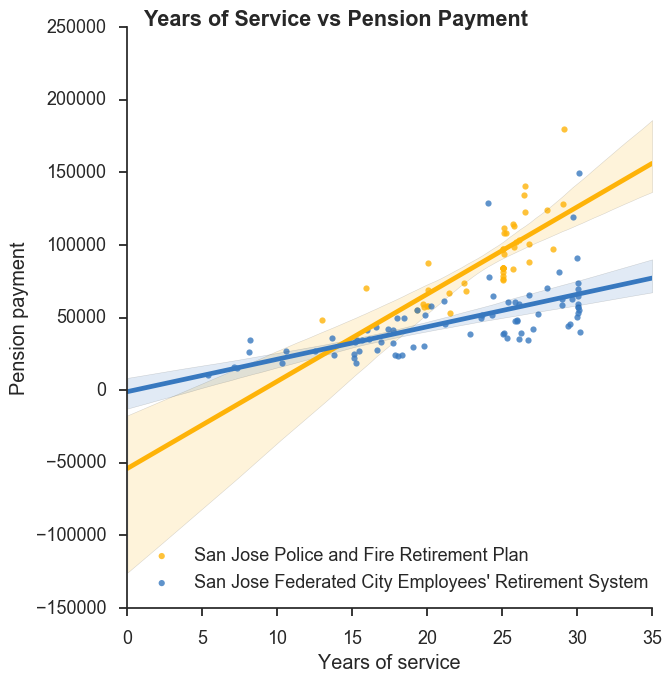

In [93]:
sns.set(style="ticks", context="talk")

colors = ["amber","windows blue", "greyish", "faded green", "dusty purple"]
pal = sns.xkcd_palette(colors)


# Plot tip as a function of toal bill across days
g = sns.lmplot(x="years_of_service", y="pension_15", hue = "pension_system", data=data,
               palette=pal, size=7,legend=False)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Years of service", "Pension payment")
g.fig.suptitle('Years of Service vs Pension Payment', fontweight="bold")

plt.legend(loc='lower left')

plt.savefig('/Users/andrewgstark/Desktop/DSI-SF-4-andrewgstark/gitpages/andrewgstark.github.io/JEKYLL-SITE-REPOSITORY-NAME/myblog/assets/service_vs_pensionpay.png',transparent=True)

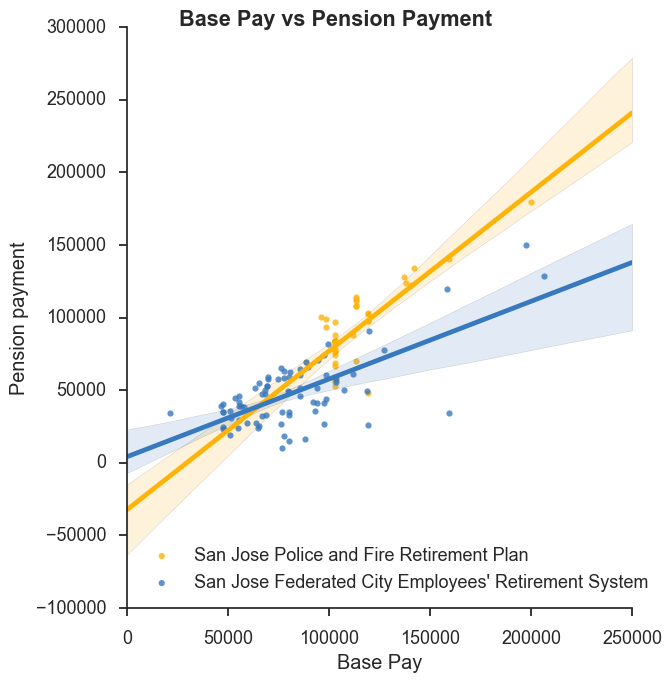

In [94]:
sns.set(style="ticks", context="talk")

# Make a custom sequential palette using the cubehelix system
colors = ["amber","windows blue", "greyish", "faded green", "dusty purple"]
pal = sns.xkcd_palette(colors)


# Plot tip as a function of toal bill across days
g = sns.lmplot(x="Base Pay-2014", y="pension_15", hue = "pension_system", data=data,
               palette=pal, size=7,legend=False)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Base Pay", "Pension payment")
g.fig.suptitle('Base Pay vs Pension Payment',fontweight='bold')

plt.legend(loc='lower left')

plt.savefig('/Users/andrewgstark/Desktop/DSI-SF-4-andrewgstark/gitpages/andrewgstark.github.io/JEKYLL-SITE-REPOSITORY-NAME/myblog/assets/base_vs_pensionpay.png',transparent=True)

Pension spikers try to get higher pensions by manipulating their final year income. Linear Regression is used to predict pensions and identify possible salary manipulation.

1. Calculate the Final Annual Salary from data in the pension file.
2. Calculate the predicted pension (predictors = "Base-Pay-13", "Base-Pay-14", years_of_service)
3. Compare the predicted pension with the actual pension. When actual pensions far exceeds predicted, investigate further.

In [99]:
# create X and y for the Police and Fire retirees
feature_cols = ['Base Pay-2014', 'Base Pay-2013', 'years_of_service']

X = data[data["pension_system"] == "San Jose Police and Fire Retirement Plan"][['Base Pay-2014', 'Base Pay-2013', 'years_of_service']]
y = data[data["pension_system"] == "San Jose Police and Fire Retirement Plan"]['pension_15']

# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print lm.intercept_
print lm.coef_

-123290.017022
[ -3.70765101e-01   1.43658167e+00   4.18719936e+03]


In [100]:
zip(feature_cols, lm.coef_)

[('Base Pay-2014', -0.37076510090664189),
 ('Base Pay-2013', 1.4365816676039278),
 ('years_of_service', 4187.1993610725049)]

In [101]:
lm.predict([100000, 97000, 25])

/Users/andrewgstark/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 83661.87867138])

Calculate the predicted pension, and the difference between predicted and actual. 

In [121]:
pred_pension_pf = data[data["pension_system"] == "San Jose Police and Fire Retirement Plan"][['Name','Base Pay-2014', 'Base Pay-2013', 'years_of_service','pension_15']]
# pred_pension_pf["predicted_pension"] = 
pred_pension_pf.reindex
pred_pension_pf.head()
predicted_pension = []
for index, row in pred_pension_pf.iterrows():
    predicted_pension.append(row["Base Pay-2014"]*(-0.37076510090664189) + row["Base Pay-2013"]*1.4365816676039278+ row["years_of_service"]*4187.1993610725049 -123290.017022)
pred_pension_pf["predicted pension"] = predicted_pension

differences = []
for index, row in pred_pension_pf.iterrows():
    differences.append(row["pension_15"] - row["predicted pension"])
pred_pension_pf["diff"] = differences

diff_pct = []
for index, row in pred_pension_pf.iterrows():
    diff_pct.append(row["diff"] / row["predicted pension"])
pred_pension_pf["diff percent"] = diff_pct


pred_pension_pf.sort_values(by="diff",inplace=True,ascending=True)
pred_pension_pf

,Name,Base Pay-2014,Base Pay-2013,years_of_service,pension_15,predicted pension,diff,diff percent
69,"Nascimento,Mike B",102772.80,97198.40,21.50,52896.00,68263.641239,-15367.641239,-0.225122
16,"Woo,Paul J",95713.60,112528.00,26.78,100800.48,115011.581198,-14211.101198,-0.123562
9,"Olmos,Albert N",159283.93,153451.03,26.50,140637.60,149058.780240,-8421.180240,-0.056496
18,"Nakamura,Tomio W",102772.80,97198.40,25.03,76223.28,83044.454984,-6821.174984,-0.082139
21,"Macheel,David M",102772.80,97198.40,25.03,76803.48,83044.454984,-6240.974984,-0.075152
82,"Phelan,Joel B",140535.20,133835.20,26.50,122795.40,127830.413238,-5035.013238,-0.039388
13,"Gibson,Steven R",102772.80,97198.40,25.04,78384.36,83086.326977,-4701.966977,-0.056591
14,"Guerrero Jr,Jose L",141835.20,141835.20,26.47,134239.68,138715.455966,-4475.775966,-0.032266
31,"Okubo,Michael K",102772.80,97198.40,20.07,58007.52,62275.946153,-4268.426153,-0.068541
73,"Daysog Jr,Jose T",102772.80,97198.40,22.58,68556.00,72785.816549,-4229.816549,-0.058113


Plot the differences between the actual and predicted pensions. Large difference can be used to prioritize future efforts like audits.

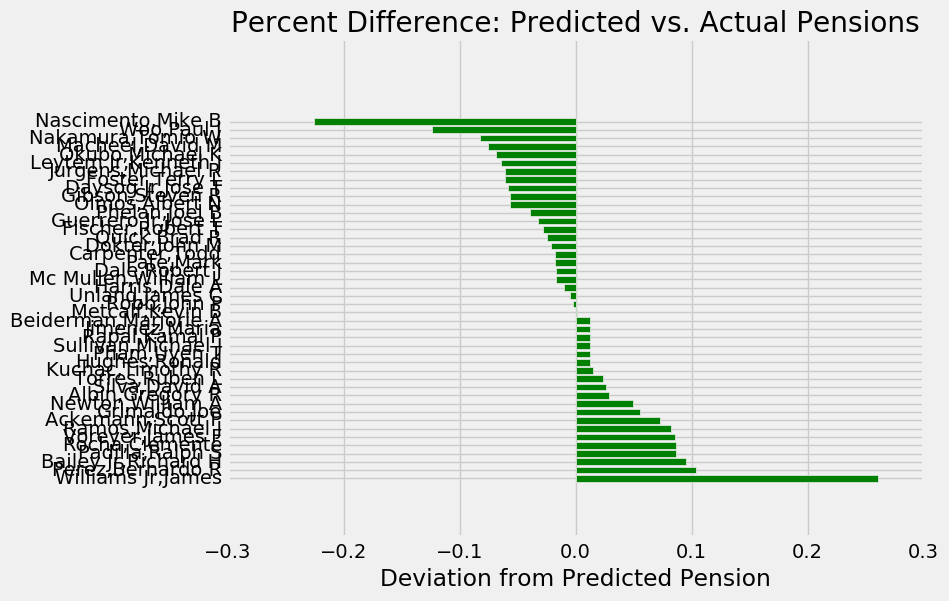

In [122]:
pred_pension_pf.sort_values(by="diff percent", ascending=True,inplace=True)

import matplotlib.pyplot as plt
plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()

# Example data
people = (pred_pension_pf.Name)
y_pos = np.arange(len(people))
difference = pred_pension_pf["diff percent"]

ax.barh(y_pos, difference, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Deviation from Predicted Pension')
ax.set_title('Percent Difference: Predicted vs. Actual Pensions')

#plt.show()
plt.savefig('/Users/andrewgstark/Desktop/DSI-SF-4-andrewgstark/gitpages/andrewgstark.github.io/JEKYLL-SITE-REPOSITORY-NAME/myblog/assets/predicted_vs_actual_pensions.png',transparent=True)

To help managers analyze pre-retirement salaries and the pensions they are receiving, I created a plot to graphically show a summary of the data.

In [118]:
import ipywidgets as widgets
from ipywidgets import Dropdown
from IPython.display import clear_output

def handlechange(variable, changed_value):
    clear_output()
    N = 3
    i = changed_value
    FAS = 0
    if data.iloc[i]["pension_system"] == "San Jose Federated City Employees' Retirement System":
        FAS = data.iloc[i]["pension_15"]/(0.025 * data.iloc[i]["years_of_service"])
    if data.iloc[i]["pension_system"] == "San Jose Police and Fire Retirement Plan":
        FAS = data.iloc[i]["pension_15"]/(0.03 * data.iloc[i]["years_of_service"])

    pension_pay = data.iloc[i]["pension_15"]
    department = data.iloc[i]["Department-2015"]
    title = data.iloc[i]["Job Title (as of 12/31/15)-2015"]
    retiree_name = data.iloc[i]["Name"]
    base_pay = (data.iloc[i]["Base Pay-2013"], data.iloc[i]["Base Pay-2014"],data.iloc[i]["Base Pay-2015"])
    overtime = (data.iloc[i]["Overtime-2013"], data.iloc[i]["Overtime-2014"],data.iloc[i]["Overtime-2015"])
    payouts = (data.iloc[i]["Sick and Vacation Payouts-2013"], data.iloc[i]["Sick and Vacation Payouts-2014"],data.iloc[i]["Sick and Vacation Payouts-2015"])
    other_comp = (data.iloc[i]["Overtime-2013"], data.iloc[i]["Overtime-2014"],data.iloc[i]["Overtime-2015"])
    years_of_service = str(data.iloc[i]["years_of_service"])

    ind = np.arange(N)    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    p1 = plt.bar(ind, base_pay, width, color='#d62728')
    p2 = plt.bar(ind, overtime, width, bottom=base_pay)
    p3 = plt.bar(ind, payouts, width, bottom=overtime, color='green')
    p4 = plt.bar(ind, other_comp, width, bottom=payouts, color='purple')

    x = [0,N-1]
    y = [pension_pay,pension_pay]
    plt.plot(x, y)

    x = [0,N-1]
    y = [FAS,FAS]
    plt.plot(x, y)

    plt.ylabel('Annual Pay')
    plt.title(retiree_name+' - '+title+'\n'+years_of_service+" years ("+department+")")
    plt.xticks(ind, ('2013', '2014', '2015'))
# plt.yticks(np.arange(0, 81, 10))
    plt.legend((p1[0], p2[0], p3[0],p4[0]), ('Base Pay', 'Overtime','Sick and Holiday Payouts','Other Pay'),loc="lower left")


    plt.show()
    return None

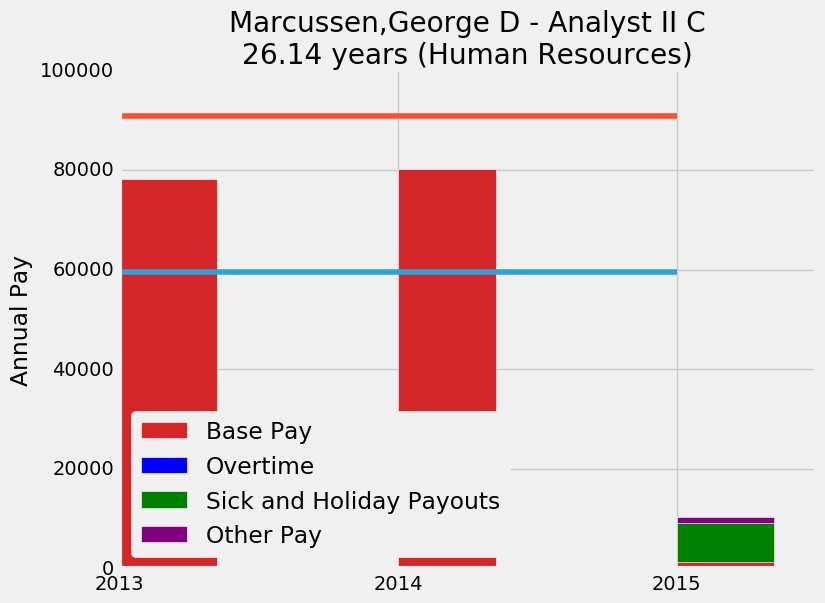

In [119]:
from ipywidgets import Dropdown
from IPython.display import clear_output

names = data["Name"].values
indices = np.arange(0,len(names))
names_and_indices = dict(zip(names, indices))

type_sel = Dropdown(description="Retiree name:", options=names_and_indices)
type_sel.on_trait_change(handlechange, name="value")
type_sel

Save the data to a file.

In [178]:
# Save the cleaned data to a csv file

data.to_csv(path_or_buf="~/Desktop/DSI-SF-4-andrewgstark/capstone/capstone_AGS_cleaned_data.csv")

In [179]:
test = pd.read_csv('~/Desktop/DSI-SF-4-andrewgstark/capstone/capstone_AGS_cleaned_data.csv')
test

,Unnamed: 0,Name,Department-2015,Job Title (as of 12/31/15)-2015,Total Cash Compensation-2015,Base Pay-2015,Overtime-2015,Sick and Vacation Payouts-2015,Other Cash Compensation-2015,Defined Contribution Plan Contributions - City Paid-2015,...,Retired?-2013,name_parts-2013,retiree_name-2013,pension_15,disability_15,total_pension_15,years_of_service,year_of_retirement,year,pension_system
0,0,"Unland,James C",Police,Police Sergeant,215941.52,13951.20,29370.18,171489.44,1130.70,NaN,...,No,"['Unland', 'James', 'C']",James Unland,102298.56,0.0,102298.56,25.92,2015,2015,San Jose Police and Fire Retirement Plan
1,1,"Larsen,Hans F",Transportation,Dir of Transportation U,200264.53,80932.21,NaN,117582.32,1750.00,NaN,...,No,"['Larsen', 'Hans', 'F']",Hans Larsen,149908.80,0.0,149908.80,30.13,2015,2015,San Jose Federated City Employees' Retirement ...
2,2,"Albin,Gregory R",Police,Police Lieutenant,196676.89,10772.80,35827.98,148189.69,1886.42,NaN,...,No,"['Albin', 'Gregory', 'R']",Gregory Albin,128167.68,0.0,128167.68,29.06,2015,2015,San Jose Police and Fire Retirement Plan
3,4,"Sullivan,Michael J",Police,Police Officer,162154.99,12052.80,21513.62,127600.25,988.32,NaN,...,No,"['Sullivan', 'Michael', 'J']",Michael Sullivan,84117.48,0.0,84117.48,25.04,2015,2015,San Jose Police and Fire Retirement Plan
4,5,"Kuchac,Timothy R",Police,Police Lieutenant,190218.89,16159.20,37782.23,134981.16,1296.30,NaN,...,No,"['Kuchac', 'Timothy', 'R']",Timothy Kuchac,123921.60,0.0,123921.60,27.99,2015,2015,San Jose Police and Fire Retirement Plan
5,6,"Torres,Ruben L",Fire,Fire Chief U,190193.03,24142.05,NaN,164279.68,1771.30,NaN,...,No,"['Torres', 'Ruben', 'L']",Ruben Torres,179610.60,0.0,179610.60,29.12,2015,2015,San Jose Police and Fire Retirement Plan
6,9,"Olmos,Albert N",Fire,Fire Division Chief,170088.79,12433.68,NaN,156198.93,1456.18,NaN,...,No,"['Olmos', 'Albert', 'N']",Albert Olmos,140637.60,0.0,140637.60,26.50,2015,2015,San Jose Police and Fire Retirement Plan
7,10,"Pham,Uyen T",Police,Police Officer,158613.16,12052.80,17829.04,126930.63,1800.69,NaN,...,No,"['Pham', 'Uyen', 'T']",Uyen Pham,84117.48,0.0,84117.48,25.04,2015,2015,San Jose Police and Fire Retirement Plan
8,11,"Foster,Terry L",Police,Police Officer,154280.33,43691.40,17686.00,89344.87,3558.06,NaN,...,No,"['Foster', 'Terry', 'L']",Terry Foster,58273.20,0.0,58273.20,20.01,2015,2015,San Jose Police and Fire Retirement Plan
9,12,"Newton,William A",Fire,Fire Captain,147130.57,52291.20,5834.47,83147.68,5857.22,NaN,...,No,"['Newton', 'William', 'A']",William Newton,108274.56,0.0,108274.56,25.24,2015,2015,San Jose Police and Fire Retirement Plan
